In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Libraries

In [82]:
import os
import glob
import zipfile
import shapefile
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import datetime
import pysal
import matplotlib
import libpysal
from pysal.explore import esda
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

# Necessary functions

In [3]:
data_dir = os.path.join(os.getcwd(),"data")
os.chdir(data_dir)

In [57]:
def get_lat_lon(sf, field, shape_dict):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shape_dict[field]]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
        data = pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])
    return data

def color_bar(heat, op):
    if len(heat) !=0:
        norm = matplotlib.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values()))
        cm=plt.get_cmap(op)
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),10), boundaries=np.arange(min(heat.values()),max(heat.values()),.1))
    return cm, norm

def get_boundaries(shapefile):
    lat, lon = [], []
    for shape in list(shapefile.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def colors_plot(heat, loc_id, continent, cm, norm):
    if len(heat) == 0:
        col = continent
    else:
        if loc_id not in heat:
            R,G,B,A = cm(norm(0))
        else:
            R,G,B,A = cm(norm(heat[loc_id]))
        col = [R,G,B]
    return col

def shapefile_part(shape, col):
    # check number of parts
    nparts = len(shape.parts)
    if nparts == 1:
        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
        ax.add_patch(patch)
    # loop over parts of each shape, plot separately
    else:
        for ip in range(nparts): # loop over parts, plot separately
            i0 = shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)

            polygon = Polygon(shape.points[i0:i1+1])
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)


def plot_map(ax, shapefile, field_id, field_zone, shape_dict,  heat={}, text=[],  op = 'Reds'):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    cm, norm = color_bar(heat, op)
    
    # iterate through every feature
    for sr in shapefile.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shape_dict[field_id]]
        zone = rec[shape_dict[field_zone]]
        
        # define color palette
        col = colors_plot(heat, loc_id, continent, cm, norm)
        
        # define colors for features
        shapefile_part(shape, col)
        
        
        # locate text
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shape_dict['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    
    # display
    limits = get_boundaries(shapefile)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [6]:
def compute_frequency(column):
    tab = column.groupby(column).agg('count')
    return tab

In [7]:
def plot_clock(radii, title, color):
    
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

# 2. Data summary

## 2.1. Data loading

In [8]:
# Load data
taxi_df = pd.read_csv("taxi_data_cleaned.csv")
# Visualize data
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,N,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36,849.0
1,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12,608.0
2,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,N,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29,29406.0
3,1,2017-03-01 00:00:00,2017-03-01 00:14:22,1,2.80,1,N,261,79,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,862.0
4,1,2017-03-01 00:00:00,2017-03-01 00:19:30,1,6.00,1,N,87,142,1,19.5,0.5,0.5,3.50,0.0,0.3,24.30,1170.0


In [9]:
# Location data

# Uncompress data
with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")
# Load data as shp
taxi_zones = shapefile.Reader("shape/taxi_zones.shp")
# Get shp attributes
fields_name = [field[0] for field in taxi_zones.fields[1:]]
# Transform attributes to dict
taxi_zones_dict = dict(zip(fields_name, list(range(len(fields_name)))))
# Record attributes
attributes = taxi_zones.records()
# Transform data to list
taxi_zones_attr = [dict(zip(fields_name, attr)) for attr in attributes]
# Create data frame
df_loc = pd.DataFrame(taxi_zones_attr).join(get_lat_lon(taxi_zones, 'LocationID', taxi_zones_dict).set_index("LocationID"), on="LocationID")
# Visualize data
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


## 2.2. Temporal trends

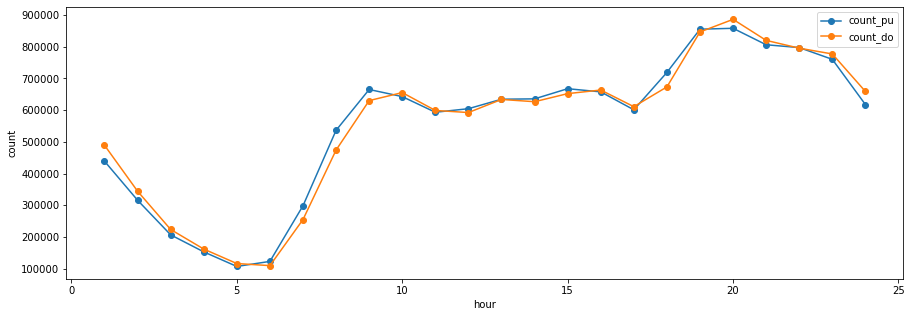

In [10]:
# Tranform to date-time
taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

# create temporal variables
# add one hour so it will start at 1h00
taxi_df['pu_hour'] = taxi_df['tpep_pickup_datetime'].dt.hour + 1
taxi_df['do_hour'] = taxi_df['tpep_dropoff_datetime'].dt.hour + 1

# Create frequencies
pu_time = pd.DataFrame({'count_pu' : taxi_df.groupby(['pu_hour']).size()}).reset_index()
do_time = pd.DataFrame({'count_do' : taxi_df.groupby(['do_hour']).size()}).reset_index()

# Join in just one dataframe
time = pu_time.join(do_time)

# Plot trend per hour
ax = time.plot(x='pu_hour', y=['count_pu', 'count_do'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
ax.set_xlabel("hour")
plt.show()

We can see that on a typical day, peak hours will be found around 7 pm to 9 pm: the hours where most workers finish their shifts. On the other hand, the off-peak hours occur mainly in the early morning,  from 5 am to 6 am when the workday begins.

In [11]:
# Visualize top three (pick ups)
tip_per_hour = taxi_df['tip_amount'].groupby(taxi_df['pu_hour']).agg('mean')
tip_per_hour.sort_values(ascending = False).head(3)

pu_hour
6     3.641859
5     3.149410
17    3.097525
Name: tip_amount, dtype: float64

In [12]:
# Visualize top three (drop offs)
tip_per_hour = taxi_df['tip_amount'].groupby(taxi_df['do_hour']).agg('mean')
tip_per_hour.sort_values(ascending = False).head(3)

do_hour
6     3.329631
17    3.014375
5     2.935383
Name: tip_amount, dtype: float64

The tips are more significant in peak hours! Especially the ones in the morning. We will create a new variable to encode this behavior: The **peak_hour** variable. It could be handy when modeling the tip amount.

In [13]:
# Create variable for peak hours
taxi_df['peak_hour'] = (taxi_df['pu_hour'].isin([6,5,17]))

In [14]:
# Compute frequency
compute_frequency(taxi_df['peak_hour'])

peak_hour
False    12460676
True       830678
Name: peak_hour, dtype: int64

Does this behaviour also occur with the days of the week?
Let's explore more

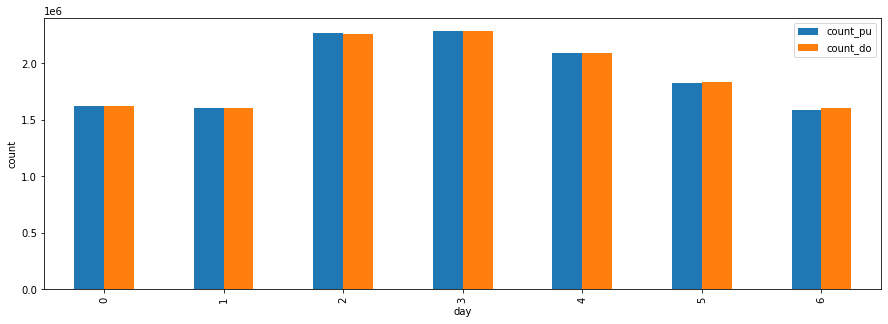

In [15]:
# create temporal variables
# add one hour so it will start at 1h00
taxi_df['pu_day'] = taxi_df['tpep_pickup_datetime'].dt.weekday
taxi_df['do_day'] = taxi_df['tpep_dropoff_datetime'].dt.weekday

# Create frequencies
pu_day = pd.DataFrame({'count_pu' : taxi_df.groupby(['pu_day']).size()}).reset_index()
do_day = pd.DataFrame({'count_do' : taxi_df.groupby(['do_day']).size()}).reset_index()

# Join in just one dataframe
day = pu_day.join(do_day)

# Plot trend per day
ax = day.plot(x='pu_day', y=['count_pu', 'count_do'], kind='bar', figsize=(15,5))
ax.set_ylabel("count")
ax.set_xlabel("day")
plt.show()

So the distribution of pickups and dropoffs is quite similar throughout the day of the week. However, more trips are occurring on Wednesday and Thursday than on other days. Maybe there is a direct relationship with the tip amount.

In [16]:
# Calculate average tips per day
tip_per_day = taxi_df['tip_amount'].groupby(taxi_df['pu_day']).agg('mean')
tip_per_day

pu_day
0    2.810282
1    2.736430
2    2.809600
3    2.860591
4    2.759621
5    2.507250
6    2.705164
Name: tip_amount, dtype: float64

No, the tips are even during the week. The days do not look like they are influencing the tip.
But bigger tips occur on Thursdays! It might be worth keeping the **pu_day** variable.
We will use it to predict the tip amount.

We found that the hour and day of the pick-up and drop-off do influence the tip amount. Intuitively, we know that not only the temporal factors can affect this value.
A passenger could have taken a cap at 5 am but only for 5 minutes, so the tip would not be generous. Contrary, another taxi user could have made a long-distance trip in off-peak hours. The tip would be significant considering the time and distance used to take him from one place to another.

Considering this, we will create new variables to explain the tip amounts based on temporal features.
 


To define if a trip is long or short, we can use two variables: duration of the trip or its distance. However, as we already included two variables that account for the time (peak hours duration will be longer due to traffic jams, high demand, etc.), we will use distance to define the trip length.

Text(0, 0.5, 'count')

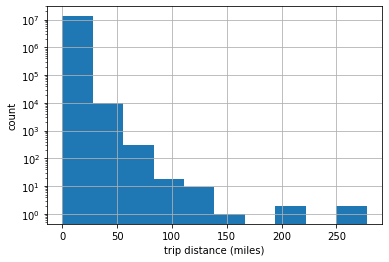

In [17]:
## Define long and short trips
ax = taxi_df['trip_distance'].hist()
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")

According to the histogram of trip distances and the fact that it takes approximately about 40 miles to drive across the whole of New York City, we decided to use 40 as the split number to categorize trips into short and long-distance trips.

In [18]:
# Define new variable (trip length)
bins = [-1, 40, np.inf]
names = [0,1]
taxi_df['trip_car'] = pd.cut(taxi_df['trip_distance'], bins, labels=names)

In [19]:
# Compute frequency
compute_frequency(taxi_df['trip_car'])

trip_car
0    13289969
1        1385
Name: trip_car, dtype: int64

Most of the trips are short trips. Let's see if there is any correlation with the tip amount.

In [20]:
# Compute average tips per trip length
taxi_df['tip_amount'].groupby(taxi_df['trip_car']).agg('mean')

trip_car
0     2.745496
1    24.261986
Name: tip_amount, dtype: float64

Longer trips translate as bigger tips! The **tip_car** variable can help us to model the tip amount.

In [21]:
# compute hours of pick ups and drop offs
trips_cat_hour = taxi_df.groupby(['trip_car','pu_hour'], as_index=False).size()
trips_cat_hour['pu_hour'] = trips_cat_hour['pu_hour'] - 1.0

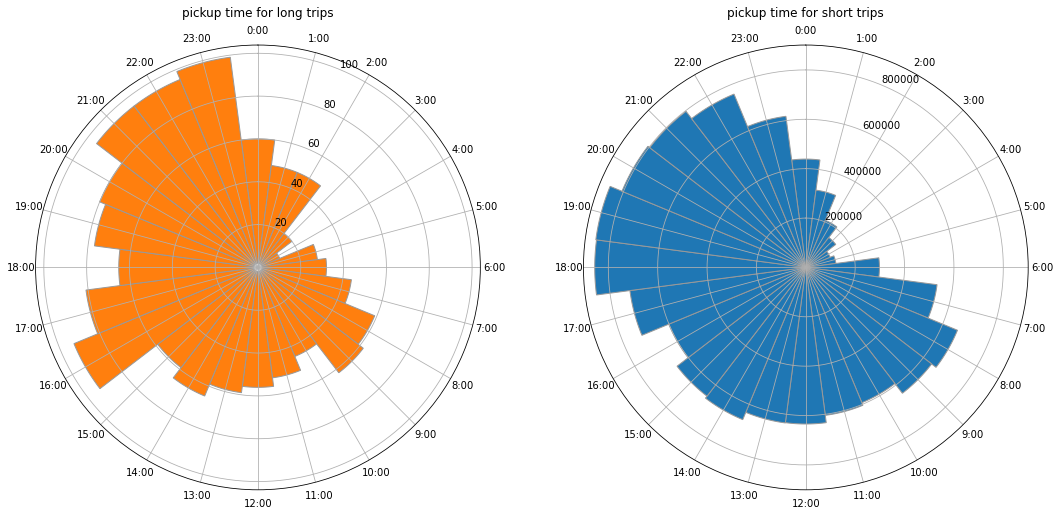

In [22]:
# define trip lenghts for plotting
pu_long = np.array(trips_cat_hour['size'][trips_cat_hour['trip_car'] == 1].tolist(), dtype="int64")
pu_short = np.array(trips_cat_hour['size'][trips_cat_hour['trip_car'] == 0].tolist(), dtype="int64")

# visualize clock plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18)) 
ax = plt.subplot(2,2,1, polar=True)
plot_clock(pu_long, 'pickup time for long trips', "#FF7F0E")
ax = plt.subplot(2,2,2, polar=True)
plot_clock(pu_short, 'pickup time for short trips', "#1F77B4")

We can observe that long trips mainly concentrate from 20h30 to 23h30. Long trips can be contributed by the passengers returning home or those who travel at night and have to get to the airport.

In the short trip, we see that most of them gather from 18h to 22h. These short trips could refer to travelers going for dinner or hanging out at night.

## 2.3. Spatial trends

Let's evaluate if the tip amount or its influencing variables interact on space. As we saw in Data exploration and cleaning, the number of pick-ups and drop-offs concentrates on some areas of NYC. We expect this behavior to occur also with covariates.

In [23]:
# Create tip averages
avg_do = pd.DataFrame({'avg' : taxi_df['tip_amount'].groupby(taxi_df['DOLocationID']).agg('mean')}).reset_index()
avg_pu = pd.DataFrame({'avg' : taxi_df['tip_amount'].groupby(taxi_df['PULocationID']).agg('mean')}).reset_index()

# Merge with location shapefile
pu_loc_df = avg_pu.merge(df_loc, left_on="PULocationID", right_on="LocationID")
do_loc_df = avg_do.merge(df_loc, left_on="DOLocationID", right_on="LocationID")

In [24]:
# Select top 3 Tip locations (pick-up)
pu_top_3 = pu_loc_df.sort_values(by=['avg'], ascending=False).set_index("PULocationID").head(3)
# Select top 3 Tip (pick-up)
do_top_3 = do_loc_df.sort_values(by=['avg'], ascending=False).set_index("DOLocationID").head(3)

# Create dict of the origin and destination tip avg
dict_pu = dict(zip(pu_loc_df['PULocationID'].tolist(), pu_loc_df['avg'].tolist()))
dict_do = dict(zip(do_loc_df['DOLocationID'].tolist(), do_loc_df['avg'].tolist()))

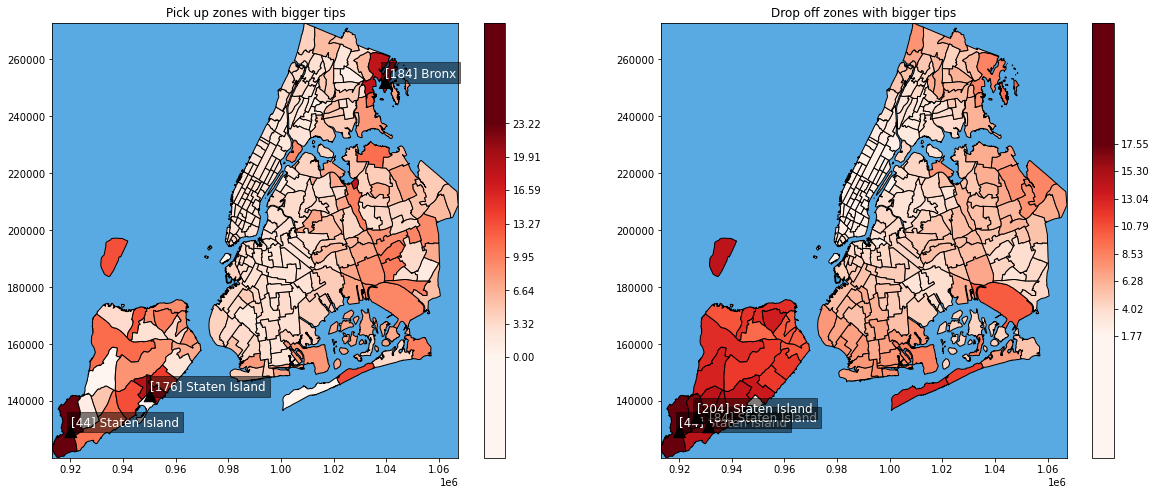

In [25]:
# Plot a map of the pick up and drop off tips

#Define subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax = plt.subplot(1, 2, 1)

# Plot maps
ax.set_title("Pick up zones with bigger tips")
plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_pu, text= pu_top_3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Drop off zones with bigger tips")
plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_do, text= do_top_3.index.tolist())

Surprisingly we see that big tips are not located in the zone where most pickups and drop-offs occur (Manhattan).

We observe that the passenger give generous tips in Staten Island. Staten Island is known for being a wealthy region. Although Manhattan and Brooklyn are also considered expensive zones, most of the inhabitants of NYC live in Staten Island, where the socioeconomic settings imitate those from NYC expensive areas, but housing and entertainment are affordable. Furthermore, Staten Island is 29 km away from Manhattan; the tips can also be associated with the long-distance trip.



In [26]:
# Select top 3 Tip locations (pick-up)
pu_bottom_3 = pu_loc_df.sort_values(by=['avg']).set_index("PULocationID").head(3)
# Select top 3 Tip (pick-up)
do_bottom_3 = do_loc_df.sort_values(by=['avg']).set_index("DOLocationID").head(3)

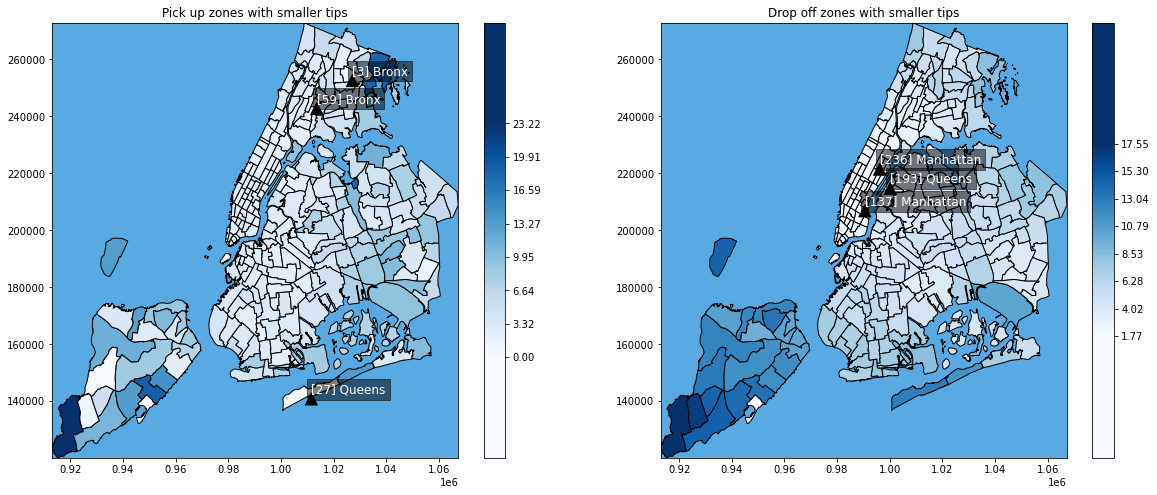

In [27]:
# Plot a map of the pick up and drop off tips

#Define subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax = plt.subplot(1, 2, 1)

# Plot maps
ax.set_title("Pick up zones with smaller tips")
plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_pu, text= pu_bottom_3.index.tolist(), op = 'Blues')
ax = plt.subplot(1, 2, 2)
ax.set_title("Drop off zones with smaller tips")
plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_do, text= do_bottom_3.index.tolist(), op = 'Blues')

The small tips for the pick-ups are mainly located in the Bronx, one of the poorest boroughs of NYC. Big tips are not common in the manhattan area, and indeed, most of the passengers that drop off in the work and entertainment region provide small tips. As they travel to the borough every day, the trip does not represent a potential memorable trip (big trip). Likewise, small tips can be linked to short trips, for example, from a restaurant to the work office in the same zone in Manhattan.

Let's check if there is any kind of spatial autocorrelation in our data.

In [95]:
# tranform to geopandas object
zip_codes = gpd.read_file('shape/taxi_zones.shp')
pu_tip_gdf = gpd.GeoDataFrame(pu_loc_df, geometry=gpd.points_from_xy(pu_loc_df.longitude, pu_loc_df.latitude), crs='ESRI:102718')
pu_tip_gdf = gpd.GeoDataFrame(do_loc_df, geometry=gpd.points_from_xy(do_loc_df.longitude, do_loc_df.latitude), crs='ESRI:102718')

### spatial join between points and zip codes
pu_df = gpd.sjoin(zip_codes, pu_tip_gdf)
do_df = gpd.sjoin(zip_codes, pu_tip_gdf)

## spatial weights
w_pu = pysal.lib.weights.Queen.from_dataframe(pu_df)
w_do = pysal.lib.weights.Queen.from_dataframe(do_df)

### moran's I
moran_tip_pu = esda.Moran_Local(pu_df['avg'], w_pu, permutations=9999)
moran_tip_do = esda.Moran_Local(do_df['avg'], w_do, permutations=9999)

# significance level
sig_pu = moran_tip_pu.p_sim < 0.05
sig_do = moran_tip_do.p_sim < 0.05

# Define hotspots and coldspots
hotspots_pu = moran_tip_pu.q==1 * sig_pu
coldspots_pu = moran_tip_pu.q==3 * sig_pu
hotspots_do = moran_tip_do.q==1 * sig_do
coldspots_do = moran_tip_do.q==3 * sig_do

C:\Anaconda\envs\python3\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 4 disconnected observations 
  Island ids: 0, 28, 84, 196
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 196, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 196, ' is an island (no neighbors)')


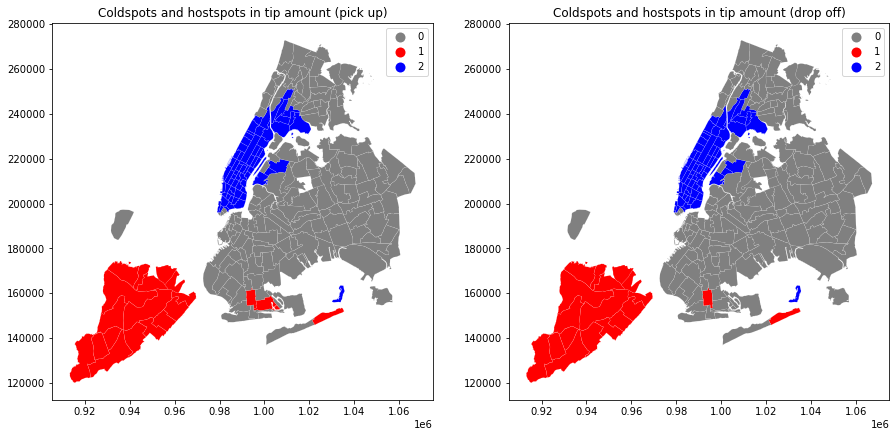

In [110]:
from matplotlib import colors

###plotting hotspots and coldspots
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold_pu = hotspots_pu*1 + coldspots_pu*2
hotcold_do = hotspots_do*1 + coldspots_do*2

# Plot hotspots and coldspots
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax = plt.subplot(1, 2, 1)
pu_df.assign(cl=hotcold_pu).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_title('Coldspots and hostspots in tip amount (pick up)')
ax = plt.subplot(1, 2, 2)
do_df.assign(cl=hotcold_do).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_title('Coldspots and hostspots in tip amount (drop off)')
plt.show()

We can see there is a clear pattern in coldspots and hotspots in the variable tip amount. Small tip amounts are concentrated in Manhattan, while significant tip amounts cluster on Staten Island.

The maps above suggest that we consider the spatial component in further modeling since it directly affects the tip amount values.


Now let's evaluate some covariates and check if they behave similarly to the tip amount.

Continous variables

In [29]:
# Tranform variables
taxi_df['passenger_count'] = taxi_df['passenger_count'].astype('float64')
taxi_df['trip_car'] = taxi_df['trip_car'].astype('int64')

In [31]:
# Select continous fields
continous_fields = ['passenger_count','trip_distance','fare_amount','duration']
# agregate by mean
continuous_do = taxi_df[continous_fields].groupby(taxi_df['DOLocationID']).agg('mean')
continuous_pu = taxi_df[continous_fields].groupby(taxi_df['PULocationID']).agg('mean')

# Merge with location shapefile
cont_pu_loc_df = continuous_pu.merge(df_loc, left_on="PULocationID", right_on="LocationID")
cont_do_loc_df = continuous_do.merge(df_loc, left_on="DOLocationID", right_on="LocationID")

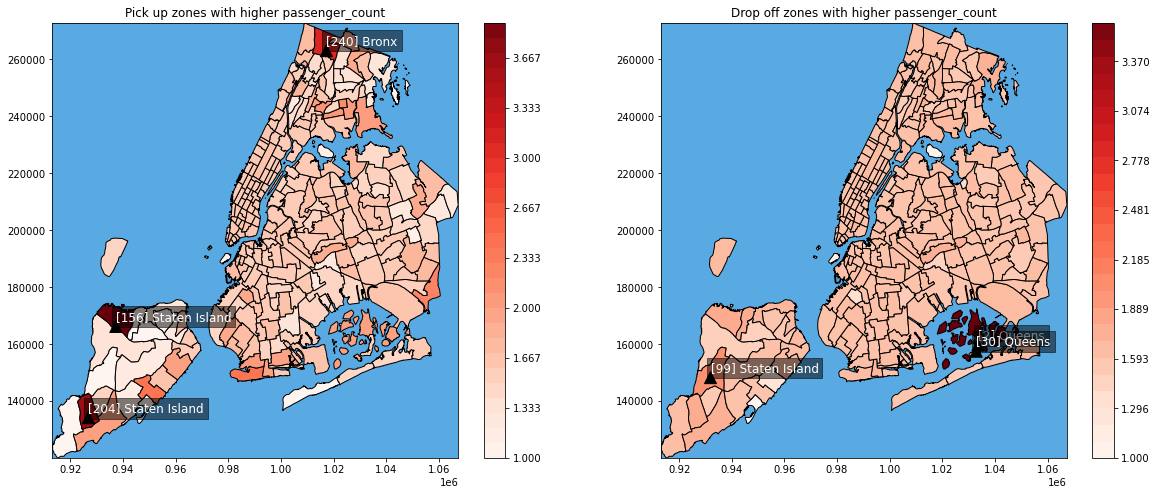

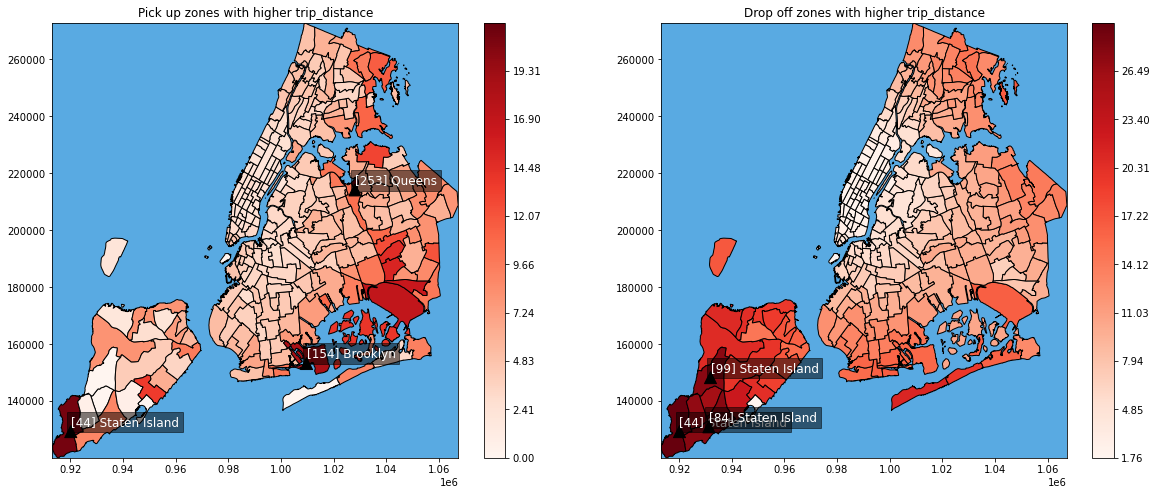

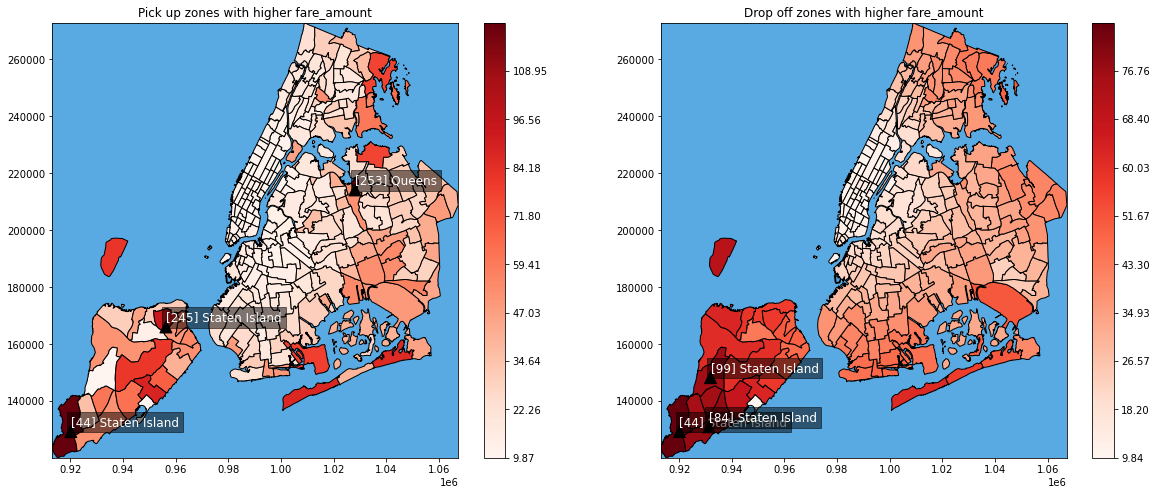

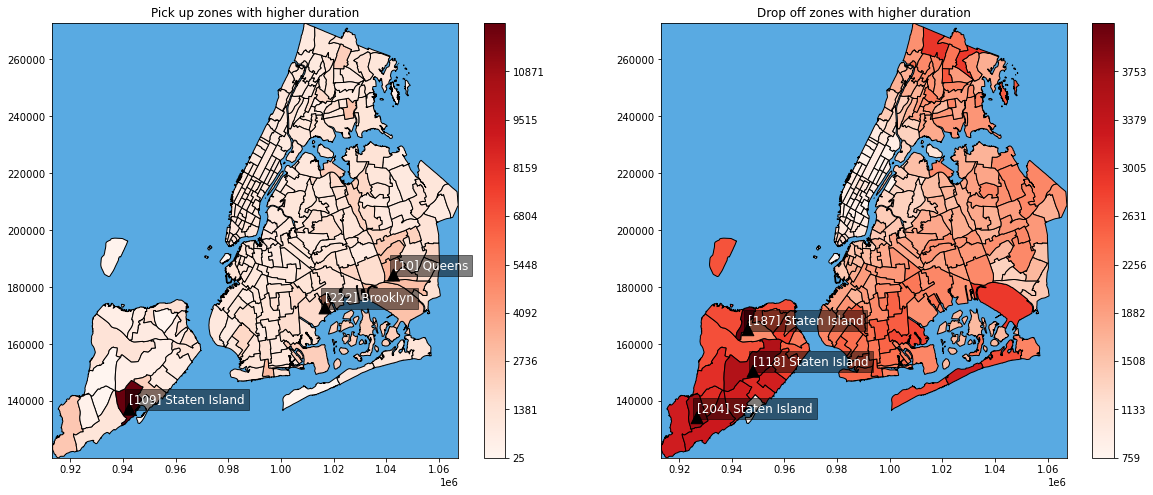

In [60]:
# Create dictionary
for field in continous_fields:
    dict_pu = dict(zip(cont_pu_loc_df['LocationID'].tolist(), cont_pu_loc_df[field].tolist()))
    dict_do = dict(zip(cont_do_loc_df['LocationID'].tolist(), cont_do_loc_df[field].tolist()))
    
    pu_top_3 = cont_pu_loc_df.sort_values(by=[field], ascending=False).set_index("LocationID").head(3)
    do_top_3 = cont_do_loc_df.sort_values(by=[field], ascending=False).set_index("LocationID").head(3)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    ax = plt.subplot(1, 2, 1)

    # Plot maps
    ax.set_title("Pick up zones with higher " +  field )
    plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_pu, text= pu_top_3.index.tolist())
    ax = plt.subplot(1, 2, 2)
    ax.set_title("Drop off zones with higher "  +  field)
    plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_do, text= do_top_3.index.tolist())

From the maps above, we can draw many conclusions:
* Staten Island region exhibits the highest values in all the continuous variables. This region is vital for further modeling of the tip amount. We should include the spatial component (regions or coordinates).
* The number of passengers is very high in the Queens borough. This is one of the most touristic places in NYC, and thus, we were expecting this behavior.
* The most extended trip distances are located in the northwest and southwest boundaries of NYC. Likewise, they are gathered in Staten Island as well.
* The fare amount variable behaves similarly to the tip amount. This must be considered in further analysis of the tip amount. The fare amount is also located in Staten Island. As we previously mentioned, this is an affluent area and also a remote region.
* It seems that the duration of the pick-ups behaves evenly through the study region. However, the spatial drop-off behavior simulates the tip amount spatial distribution. This variable would have a direct impact on the tip amount prediction.


Discrete variables

In [41]:
# Select discrete fields
discrete_fields = ['RatecodeID', 'trip_car']

# agregate by max vaalue or factor
discrete_do = taxi_df[discrete_fields].groupby(taxi_df['DOLocationID']).agg('max')
discrete_pu = taxi_df[discrete_fields].groupby(taxi_df['PULocationID']).agg('max')

# Merge with location shapefile
disc_pu_loc_df = discrete_pu.merge(df_loc, left_on="PULocationID", right_on="LocationID")
disc_do_loc_df = discrete_do.merge(df_loc, left_on="DOLocationID", right_on="LocationID")

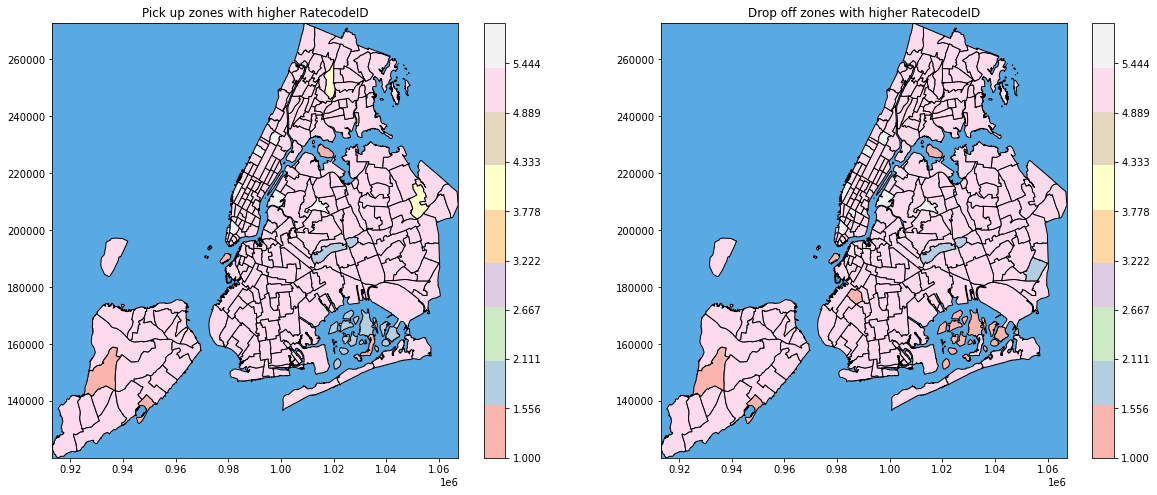

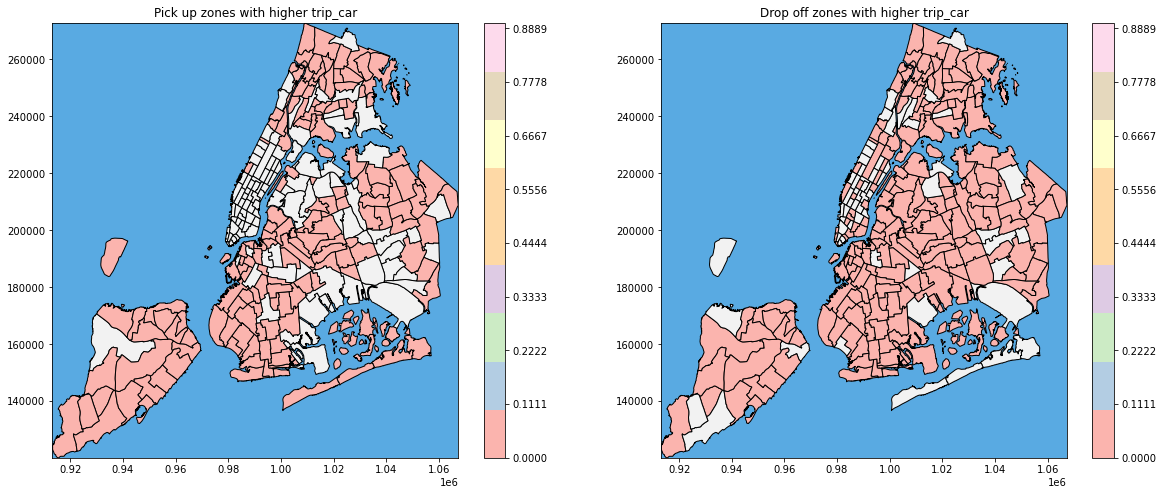

In [58]:
# Create dictionary
for field in discrete_fields:
    dict_pu = dict(zip(disc_pu_loc_df['LocationID'].tolist(), disc_pu_loc_df[field].tolist()))
    dict_do = dict(zip(disc_do_loc_df['LocationID'].tolist(), disc_do_loc_df[field].tolist()))
    
    pu_top_3 = disc_pu_loc_df.sort_values(by=[field], ascending=False).set_index("LocationID").head(3)
    do_top_3 = disc_do_loc_df.sort_values(by=[field], ascending=False).set_index("LocationID").head(3)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    ax = plt.subplot(1, 2, 1)

    # Plot maps
    ax.set_title("Pick up zones with higher " +  field )
    plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_pu, text= [0], op = 'Pastel1')
    ax = plt.subplot(1, 2, 2)
    ax.set_title("Drop off zones with higher "  +  field)
    plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_do, text= [0], op = 'Pastel1')

Generally, NYC travelers pay the standard rate. But in some regions of Manhattan and the Broad Channel, the users pay the JKF rate. This one refers to the JKF airport. It occurs in both the pick-ups and drop-offs.

In terms of the trip lengths, the short trips do not exhibit a clear spatial pattern. Most of the short trips begin in the boroughs of Brooklyn and Queens and finish in neighboring boroughs. Shor trips are also frequent in Manhattan. 

Long trips are scattered all over NYC. The JKF airport, La Guardia Airport, and Newark Airport are zones where many passengers drop off after a long trip. Staten Island and the center of Manhattan are also zones where long trips occur.


# 2.4. Other insights

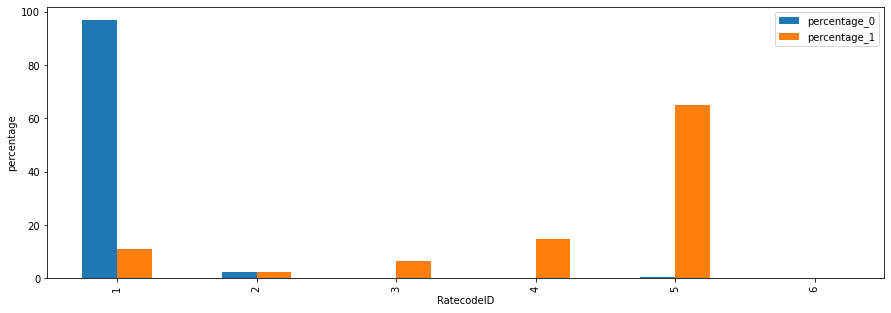

In [165]:
# Create frequencies
pu_day = pd.DataFrame({'count_0' : taxi_df[taxi_df['trip_car']== 0].groupby(['RatecodeID']).size()}).reset_index()
do_day = pd.DataFrame({'count_1' : taxi_df[taxi_df['trip_car']== 1].groupby(['RatecodeID']).size()}).reset_index()

# Join in just one dataframe
day = pu_day.join(do_day, lsuffix='_caller', rsuffix='_other')
day['percentage_0'] = 100 * day['count_0'] / day['count_0'].sum()
day['percentage_1'] = 100 * day['count_1'] / day['count_1'].sum()

# Plot trend per day
ax = day.plot(x='RatecodeID_caller', y=['percentage_0', 'percentage_1'], kind='bar', figsize=(15,5))
ax.set_ylabel("percentage")
ax.set_xlabel("RatecodeID")
plt.show()

We can see that more than 50 percent of long trips use Negotiated fare, and another 40 percent of long trips use JFK, Newark, or Nassau, or Westchester.
Travelers who take short trips use the standard rate.

In [ ]:
# Create frequencies
pu_time = pd.DataFrame({'count_pu' : taxi_df.groupby(['trip_distance']).size()}).reset_index()
do_time = pd.DataFrame({'count_do' : taxi_df.groupby(['trip_distance']).size()}).reset_index()

# Join in just one dataframe
time = pu_time.join(do_time)

# Plot trend per hour
ax = time.plot(x='pu_hour', y=['count_pu', 'count_do'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
ax.set_xlabel("hour")
plt.show()

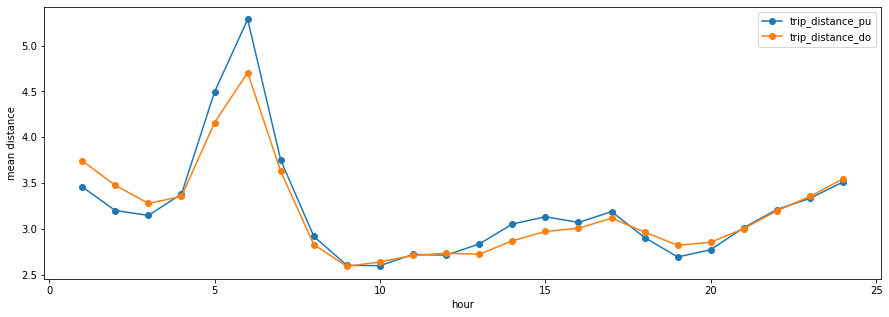

In [178]:
pu_distance =  taxi_df.groupby('pu_hour')['trip_distance'].mean().reset_index()
do_distance =  taxi_df.groupby('do_hour')['trip_distance'].mean().reset_index()

# Join in just one dataframe
time = pu_distance.join(do_distance, lsuffix='_pu', rsuffix='_do')

# Plot trend per hour
ax = time.plot(x='pu_hour', y=['trip_distance_pu', 'trip_distance_do'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("mean distance")
ax.set_xlabel("hour")
plt.show()

The relatively long-distance trip of taxi takes place during 5h00 7h00.
The relatively short-distance trip time range is 9h00 - 11h00 and 19h00 - 20h00.
There are appropriate values because those time slots are the everyday work and daily operation times.


In [179]:
# Export cleaned data set
taxi_df.to_csv('taxi_data_cleaned.csv', index=False)

# Summary

We explore the principal trends in our data. We also screen our variables deeply, and we derived others that could help us predict the tip amount. For example, we created the day and hours variables that influence the tip amount and many other variables!

In this section, we found that our data have spatial and temporal features. This can give us an initial idea of how to model the tip amount. We have to be careful when deciding on a suitable model. However, it must be said that even the tip amount depends on space and time. These variables can be added as simple regressors. A Spatio-temporal model could not be suitable given the data structure (points with a spatial component at polygon-level).

Considering this data summary, we already know which variables to use in the tip amount prediction model and the importance of including the spatial and temporal factors.